In [1]:
#Load libraries
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


#checking for device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
#Transforms
transformer=transforms.Compose([
    transforms.Resize((300,300)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    torchvision.transforms.Grayscale(num_output_channels=1)
])

#dataloader
train_path =  r"C:\Dataset\Train_set"
test_path = r"C:\Dataset\Test_set"
train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=32, shuffle=True
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transformer),
    batch_size=16, shuffle=True
)
#categories
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])
print(classes)

cuda
['L4', 'day1', 'day10', 'day11', 'day12', 'day13', 'day14', 'day15', 'day16', 'day17', 'day18', 'day19', 'day2', 'day20', 'day21', 'day3', 'day4', 'day5', 'day6', 'day7', 'day8', 'day9', 'others']


In [2]:
import torch
import torch.nn as nn
from math import ceil

base_model = [
    # expand_ratio, channels, repeats, stride, kernel_size
    [1, 16, 1, 1, 3],
    [6, 24, 2, 2, 3],
    [6, 40, 2, 2, 5],
    [6, 80, 3, 2, 3],
    [6, 112, 3, 1, 5],
    [6, 192, 4, 2, 5],
    [6, 320, 1, 1, 3],
]

phi_values = {
    # tuple of: (phi_value, resolution, drop_rate)
    "b0": (0, 224, 0.2),  # alpha, beta, gamma, depth = alpha ** phi
    "b1": (0.5, 240, 0.2),
    "b2": (1, 260, 0.3),
    "b3": (2, 300, 0.3),
    "b4": (3, 380, 0.4),
    "b5": (4, 456, 0.4),
    "b6": (5, 528, 0.5),
    "b7": (6, 600, 0.5),
}

class CNNBlock(nn.Module):
    def __init__(
            self, in_channels, out_channels, kernel_size, stride, padding, groups=1
    ):
        super(CNNBlock, self).__init__()
        self.cnn = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            groups=groups,
            bias=False,
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.silu = nn.SiLU() # SiLU <-> Swish

    def forward(self, x):
        return self.silu(self.bn(self.cnn(x)))

class SqueezeExcitation(nn.Module):
    def __init__(self, in_channels, reduced_dim):
        super(SqueezeExcitation, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), # C x H x W -> C x 1 x 1
            nn.Conv2d(in_channels, reduced_dim, 1),
            nn.SiLU(),
            nn.Conv2d(reduced_dim, in_channels, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return x * self.se(x)

class InvertedResidualBlock(nn.Module):
    def __init__(
            self,
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            expand_ratio,
            reduction=4, # squeeze excitation
            survival_prob=0.8, # for stochastic depth
    ):
        super(InvertedResidualBlock, self).__init__()
        self.survival_prob = 0.8
        self.use_residual = in_channels == out_channels and stride == 1
        hidden_dim = in_channels * expand_ratio
        self.expand = in_channels != hidden_dim
        reduced_dim = int(in_channels / reduction)

        if self.expand:
            self.expand_conv = CNNBlock(
                in_channels, hidden_dim, kernel_size=3, stride=1, padding=1,
            )

        self.conv = nn.Sequential(
            CNNBlock(
                hidden_dim, hidden_dim, kernel_size, stride, padding, groups=hidden_dim,
            ),
            SqueezeExcitation(hidden_dim, reduced_dim),
            nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

    def stochastic_depth(self, x):
        if not self.training:
            return x

        binary_tensor = torch.rand(x.shape[0], 1, 1, 1, device=x.device) < self.survival_prob
        return torch.div(x, self.survival_prob) * binary_tensor

    def forward(self, inputs):
        x = self.expand_conv(inputs) if self.expand else inputs

        if self.use_residual:
            return self.stochastic_depth(self.conv(x)) + inputs
        else:
            return self.conv(x)


class EfficientNet(nn.Module):
    def __init__(self, version, num_classes):
        super(EfficientNet, self).__init__()
        width_factor, depth_factor, dropout_rate = self.calculate_factors(version)
        last_channels = ceil(1280 * width_factor)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.features = self.create_features(width_factor, depth_factor, last_channels)
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(last_channels, num_classes),
        )

    def calculate_factors(self, version, alpha=1.2, beta=1.1):
        phi, res, drop_rate = phi_values[version]
        depth_factor = alpha ** phi
        width_factor = beta ** phi
        return width_factor, depth_factor, drop_rate

    def create_features(self, width_factor, depth_factor, last_channels):
        channels = int(32 * width_factor)
        features = [CNNBlock(1, channels, 3, stride=2, padding=1)]
        in_channels = channels

        for expand_ratio, channels, repeats, stride, kernel_size in base_model:
            out_channels = 4*ceil(int(channels*width_factor) / 4)
            layers_repeats = ceil(repeats * depth_factor)

            for layer in range(layers_repeats):
                features.append(
                    InvertedResidualBlock(
                        in_channels,
                        out_channels,
                        expand_ratio=expand_ratio,
                        stride = stride if layer == 0 else 1,
                        kernel_size=kernel_size,
                        padding=kernel_size//2, # if k=1:pad=0, k=3:pad=1, k=5:pad=2
                    )
                )
                in_channels = out_channels

        features.append(
            CNNBlock(in_channels, last_channels, kernel_size=1, stride=1, padding=0)
        )

        return nn.Sequential(*features)

    def forward(self, x):
        x = self.pool(self.features(x))
        return self.classifier(x.view(x.shape[0], -1))

In [3]:
model=EfficientNet("b1", num_classes=23).to(device)
#Optmizer and loss function
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()
#calculating the size of training and testing images
train_count=len(glob.glob(train_path+'/**/*.jpg'))
test_count=len(glob.glob(test_path+'/**/*.jpg'))
print(train_count,test_count)

77846 23666


In [4]:
import torch
import shutil
def save_ckp(state, is_best, checkpoint_path, best_model_path):
    f_path = checkpoint_path
    torch.save(state, f_path)
    if is_best:
        best_fpath = best_model_path
        shutil.copyfile(f_path, best_fpath)

In [5]:
y_pred = []
y_true = []
train_losses = []
test_accuracies = []
best_accuracy= 0.0
test_accuracy=0.0
train_accuracy=0.0
train_loss=0.0

In [6]:
def train_test(start_epochs, best_accuracy,train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred):
    #Model training and saving best model

    for epoch in range(start_epochs, num_epochs+1):

        #Evaluation and training on training dataset
        model.train()

        for i, (images,labels) in enumerate(train_loader):
            if torch.cuda.is_available():
                images=Variable(images.cuda())
                labels=Variable(labels.cuda())

            optimizer.zero_grad()

            outputs=model(images)
            loss=loss_function(outputs,labels)
            loss.backward()
            optimizer.step()

            train_loss+= loss.cpu().data*images.size(0)
            _,prediction=torch.max(outputs.data,1)

            train_accuracy+=int(torch.sum(prediction==labels.data))

        train_accuracy=train_accuracy/train_count
        train_loss=train_loss/train_count

        # Evaluation on testing dataset
        model.eval()

        for i, (images,labels) in enumerate(test_loader):
            if torch.cuda.is_available():
                images=Variable(images.cuda())
                labels=Variable(labels.cuda())

            outputs=model(images)
            _,prediction=torch.max(outputs.data,1)
            test_accuracy+=int(torch.sum(prediction==labels.data))

            output = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
            y_pred.extend(output) # Save Prediction

            labels = labels.data.cpu().numpy()
            y_true.extend(labels) # Save Truth

        test_accuracy=test_accuracy/test_count

        print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
        
        train_losses.append(train_loss.item())
        test_accuracies.append(test_accuracy)
        checkpoint = {
                'start_epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'best_accuracy': best_accuracy,
                'train_accuracy': train_accuracy,
                'test_accuracy': test_accuracy,
                'train_loss': train_loss,
                'train_losses':train_losses,
                'test_accuracies': test_accuracies,
                'y_true': y_true,
                'y_pred': y_pred
        }
        save_ckp(checkpoint, False, checkpoint_path='current_checkpoint_efficientNet_b1.pt', best_model_path='best_checkpoint_efficientNet_b1.model')
        #Save the best model
        if test_accuracy>best_accuracy:
            torch.save(model.state_dict(),'best_checkpoint_efficientNet_b1.model')
            best_accuracy=test_accuracy
            checkpoint['best_accuracy']=best_accuracy
            save_ckp(checkpoint, True, checkpoint_path='current_checkpoint_efficientNet_b1.pt', best_model_path='best_checkpoint_efficientNet_b1.model')

In [7]:
def load_ckp(checkpoint_fpath, model, optimizer):
    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    best_accuracy = checkpoint['best_accuracy']
    train_accuracy = checkpoint['train_accuracy']
    test_accuracy = checkpoint['test_accuracy']
    train_loss = checkpoint['train_loss']    
    train_losses = checkpoint['train_losses']    
    test_accuracies = checkpoint['test_accuracies']   
    start_epoch = checkpoint['start_epoch']
    y_true = checkpoint['y_true']
    y_pred = checkpoint['y_pred']
    return model, optimizer,start_epoch,best_accuracy, train_accuracy,test_accuracy,train_loss.item(),train_losses,test_accuracies,y_true,y_pred

In [8]:
def conf_matrix(y_true,y_pred):
     # constant for classes
    #classes = ('L4', 'day1', 'day10', 'day11', 'day12', 'day13', 'day14', 'day15', 'day16', 'day17', 'day18', 'day19', 'day2', 'day20', 'day21', 'day3', 'day4', 'day5', 'day6', 'day7', 'day8', 'day9', 'others')

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix), index = [i for i in classes],
                         columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    sn.heatmap(df_cm, annot=True)
    plt.savefig('output.png')

In [9]:
def learn_curve_train_losses(train_losses):
    plt.plot(train_losses,'-o')
    plt.xlabel('epoch')
    plt.ylabel('losses')
    plt.legend(['Train'])
    plt.title('Train Losses Per Epoch')

    plt.show()
    
def learn_curve_test_accuracies(test_accuracies):
    plt.plot(test_accuracies,'-r')
    plt.xlabel('epoch')
    plt.ylabel('test_accuracy')
    plt.legend(['Test Accuracy'])
    plt.title('Test Accuracy Per Epoch')
    plt.show()


In [10]:
num_epochs = 1

import os.path

if os.path.isfile("current_checkpoint_effecientNet_b1.pt"):
    ckp_path = "current_checkpoint_efficientNet_b1.pt"
    model, optimizer, start_epoch, best_accuracy, train_accuracy,test_accuracy,train_loss,train_losses,test_accuracies,y_true,y_pred  = load_ckp(ckp_path, model, optimizer)
    train_test(start_epoch, best_accuracy,train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)
else:
    train_test(1,best_accuracy, train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)

Epoch: 1 Train Loss: tensor(2.6033) Train Accuracy: 0.16244893764612184 Test Accuracy: 0.19339981407926984


In [ ]:
num_epochs = 25

import os.path

if os.path.isfile("current_checkpoint_efficientNet_b1.pt"):
    ckp_path = "current_checkpoint_efficientNet_b1.pt"
    model, optimizer, start_epoch, best_accuracy, train_accuracy,test_accuracy,train_loss,train_losses,test_accuracies,y_true,y_pred  = load_ckp(ckp_path, model, optimizer)
    train_test(start_epoch, best_accuracy,train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)
else:
    train_test(1,best_accuracy, train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)

Epoch: 2 Train Loss: tensor(2.2262) Train Accuracy: 0.23630196090920083 Test Accuracy: 0.2123380968399425
Epoch: 3 Train Loss: tensor(1.9755) Train Accuracy: 0.3160629486673806 Test Accuracy: 0.37294905510423565
Epoch: 4 Train Loss: tensor(1.6454) Train Accuracy: 0.4377401030617972 Test Accuracy: 0.4721276493304785
Epoch: 5 Train Loss: tensor(1.3573) Train Accuracy: 0.542898000412392 Test Accuracy: 0.525203757612158
Epoch: 6 Train Loss: tensor(1.1696) Train Accuracy: 0.6075141034606841 Test Accuracy: 0.5688973719157278
Epoch: 7 Train Loss: tensor(1.0358) Train Accuracy: 0.6542867650759636 Test Accuracy: 0.5670822655865764
Epoch: 8 Train Loss: tensor(0.9333) Train Accuracy: 0.6871728063967971 Test Accuracy: 0.6209146912137914
Epoch: 9 Train Loss: tensor(0.8535) Train Accuracy: 0.7144450218740385 Test Accuracy: 0.6278467385570529
Epoch: 10 Train Loss: tensor(0.7936) Train Accuracy: 0.7360649801534038 Test Accuracy: 0.6464391044848541
Epoch: 11 Train Loss: tensor(0.7355) Train Accuracy: 0

In [ ]:
num_epochs = 25

import os.path

if os.path.isfile("current_checkpoint_efficientNet_b1.pt"):
    ckp_path = "current_checkpoint_efficientNet_b1.pt"
    model, optimizer, start_epoch, best_accuracy, train_accuracy,test_accuracy,train_loss,train_losses,test_accuracies,y_true,y_pred  = load_ckp(ckp_path, model, optimizer)
    train_test(start_epoch, best_accuracy,train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)
else:
    train_test(1,best_accuracy, train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)

Epoch: 14 Train Loss: tensor(0.6058) Train Accuracy: 0.7998456699550198 Test Accuracy: 0.6915270169827078


In [ ]:
num_epochs = 25

import os.path

if os.path.isfile("current_checkpoint_efficientNet_b1.pt"):
    ckp_path = "current_checkpoint_efficientNet_b1.pt"
    model, optimizer, start_epoch, best_accuracy, train_accuracy,test_accuracy,train_loss,train_losses,test_accuracies,y_true,y_pred  = load_ckp(ckp_path, model, optimizer)
    train_test(start_epoch, best_accuracy,train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)
else:
    train_test(1,best_accuracy, train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)

Epoch: 15 Train Loss: tensor(0.5791) Train Accuracy: 0.8100069347900979 Test Accuracy: 0.682907611215118
Epoch: 16 Train Loss: tensor(0.5481) Train Accuracy: 0.8190505614538292 Test Accuracy: 0.6991330561823382


In [ ]:
num_epochs = 40

import os.path

if os.path.isfile("current_checkpoint_efficientNet_b1.pt"):
    ckp_path = "current_checkpoint_efficientNet_b1.pt"
    model, optimizer, start_epoch, best_accuracy, train_accuracy,test_accuracy,train_loss,train_losses,test_accuracies,y_true,y_pred  = load_ckp(ckp_path, model, optimizer)
    train_test(start_epoch, best_accuracy,train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)
else:
    train_test(1,best_accuracy, train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)

Epoch: 17 Train Loss: tensor(0.5217) Train Accuracy: 0.8285951628929098 Test Accuracy: 0.7041620524404708
Epoch: 18 Train Loss: tensor(0.4989) Train Accuracy: 0.8350310689715964 Test Accuracy: 0.7096131227098977
Epoch: 19 Train Loss: tensor(0.4727) Train Accuracy: 0.8434965833963077 Test Accuracy: 0.7026835803736461
Epoch: 20 Train Loss: tensor(0.4508) Train Accuracy: 0.8511785255065566 Test Accuracy: 0.6776262437074442
Epoch: 21 Train Loss: tensor(0.4382) Train Accuracy: 0.8557260640049008 Test Accuracy: 0.7004427290730882
Epoch: 22 Train Loss: tensor(0.4204) Train Accuracy: 0.8616994543851194 Test Accuracy: 0.7249514257892788
Epoch: 23 Train Loss: tensor(0.4079) Train Accuracy: 0.8653220679219791 Test Accuracy: 0.7207269902571533
Epoch: 24 Train Loss: tensor(0.3850) Train Accuracy: 0.8736333957052119 Test Accuracy: 0.7477275723396543
Epoch: 25 Train Loss: tensor(0.3793) Train Accuracy: 0.8737748070985755 Test Accuracy: 0.7275732159035045
Epoch: 26 Train Loss: tensor(0.3667) Train Acc

In [ ]:
num_epochs = 50

import os.path

if os.path.isfile("current_checkpoint_efficientNet_b1.pt"):
    ckp_path = "current_checkpoint_efficientNet_b1.pt"
    model, optimizer, start_epoch, best_accuracy, train_accuracy,test_accuracy,train_loss,train_losses,test_accuracies,y_true,y_pred  = load_ckp(ckp_path, model, optimizer)
    train_test(start_epoch, best_accuracy,train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)
else:
    train_test(1,best_accuracy, train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)

Epoch: 38 Train Loss: tensor(0.2640) Train Accuracy: 0.9134047885011316 Test Accuracy: 0.7658984641546416
Epoch: 39 Train Loss: tensor(0.2624) Train Accuracy: 0.9142398248437749 Test Accuracy: 0.7664905729089898
Epoch: 40 Train Loss: tensor(0.2593) Train Accuracy: 0.9144196778232001 Test Accuracy: 0.7795050490396734
Epoch: 41 Train Loss: tensor(0.2503) Train Accuracy: 0.9167190917924855 Test Accuracy: 0.7725335715815532
Epoch: 42 Train Loss: tensor(0.2504) Train Accuracy: 0.9180807841005548 Test Accuracy: 0.7729980788291887
Epoch: 43 Train Loss: tensor(0.2433) Train Accuracy: 0.9189029376048108 Test Accuracy: 0.7752798528724257
Epoch: 44 Train Loss: tensor(0.2417) Train Accuracy: 0.9212280515753875 Test Accuracy: 0.7500116318707375
Epoch: 45 Train Loss: tensor(0.2373) Train Accuracy: 0.9213950778209745 Test Accuracy: 0.7755324098551454
Epoch: 46 Train Loss: tensor(0.2326) Train Accuracy: 0.9233733447457522 Test Accuracy: 0.7674205836393921
Epoch: 47 Train Loss: tensor(0.2320) Train Acc

In [ ]:
num_epochs = 70

import os.path

if os.path.isfile("current_checkpoint_efficientNet_b1.pt"):
    ckp_path = "current_checkpoint_efficientNet_b1.pt"
    model, optimizer, start_epoch, best_accuracy, train_accuracy,test_accuracy,train_loss,train_losses,test_accuracies,y_true,y_pred  = load_ckp(ckp_path, model, optimizer)
    train_test(start_epoch, best_accuracy,train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)
else:
    train_test(1,best_accuracy, train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)

Epoch: 48 Train Loss: tensor(0.2215) Train Accuracy: 0.9279978908374215 Test Accuracy: 0.7778997003193964
Epoch: 49 Train Loss: tensor(0.2253) Train Accuracy: 0.9259426046025593 Test Accuracy: 0.7836464928462908
Epoch: 50 Train Loss: tensor(0.2189) Train Accuracy: 0.9284860614881253 Test Accuracy: 0.7576178334527528
Epoch: 51 Train Loss: tensor(0.2154) Train Accuracy: 0.9304386671898555 Test Accuracy: 0.7708424582875625


In [10]:
num_epochs = 70

import os.path

if os.path.isfile("current_checkpoint_efficientNet_b1.pt"):
    ckp_path = "current_checkpoint_efficientNet_b1.pt"
    model, optimizer, start_epoch, best_accuracy, train_accuracy,test_accuracy,train_loss,train_losses,test_accuracies,y_true,y_pred  = load_ckp(ckp_path, model, optimizer)
    train_test(start_epoch, best_accuracy,train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)
else:
    train_test(1,best_accuracy, train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)

Epoch: 52 Train Loss: tensor(0.2133) Train Accuracy: 0.9302716958953213 Test Accuracy: 0.7940408536490445
Epoch: 53 Train Loss: tensor(0.2108) Train Accuracy: 0.931325055515966 Test Accuracy: 0.7666185261917371
Epoch: 54 Train Loss: tensor(0.2070) Train Accuracy: 0.9324169684383978 Test Accuracy: 0.7928152885374035
Epoch: 55 Train Loss: tensor(0.2051) Train Accuracy: 0.932147219085996 Test Accuracy: 0.7660269084462324
Epoch: 56 Train Loss: tensor(0.2003) Train Accuracy: 0.9339970216481139 Test Accuracy: 0.7594340415325127
Epoch: 57 Train Loss: tensor(0.2040) Train Accuracy: 0.932545461514036 Test Accuracy: 0.7851246274842192
Epoch: 58 Train Loss: tensor(0.1987) Train Accuracy: 0.9349861591534763 Test Accuracy: 0.7735901768202267
Epoch: 59 Train Loss: tensor(0.1947) Train Accuracy: 0.9358854017696369 Test Accuracy: 0.7904070645726705
Epoch: 60 Train Loss: tensor(0.1959) Train Accuracy: 0.9358083380700584 Test Accuracy: 0.7872809265217855
Epoch: 61 Train Loss: tensor(0.1912) Train Accura

In [11]:
print(best_accuracy)

0.7836464928462908


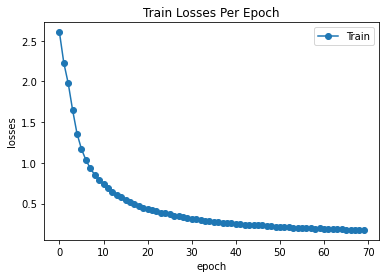

In [12]:
learn_curve_train_losses(train_losses)

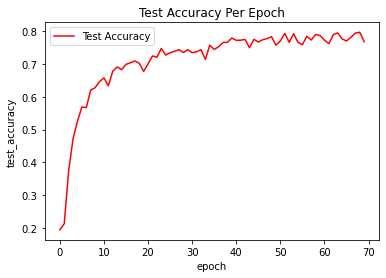

In [13]:
learn_curve_test_accuracies(test_accuracies)

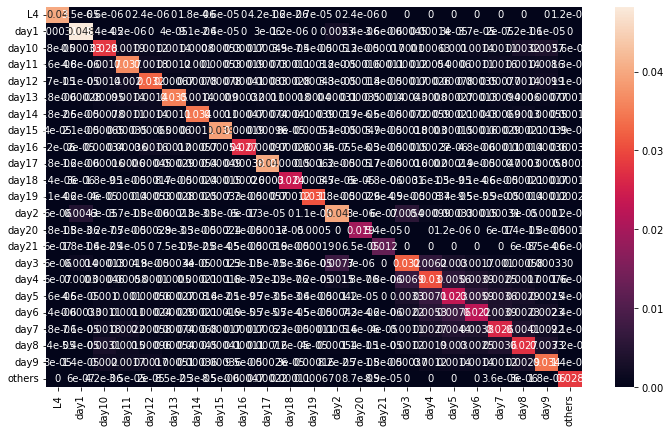

In [14]:
conf_matrix(y_true,y_pred)

In [ ]:
num_epochs = 100

import os.path

if os.path.isfile("current_checkpoint_efficientNet_b1.pt"):
    ckp_path = "current_checkpoint_efficientNet_b1.pt"
    model, optimizer, start_epoch, best_accuracy, train_accuracy,test_accuracy,train_loss,train_losses,test_accuracies,y_true,y_pred  = load_ckp(ckp_path, model, optimizer)
    train_test(start_epoch, best_accuracy,train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)
else:
    train_test(1,best_accuracy, train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)

Epoch: 71 Train Loss: tensor(0.1759) Train Accuracy: 0.9426809652907283 Test Accuracy: 0.7979281728992361
Epoch: 72 Train Loss: tensor(0.1755) Train Accuracy: 0.9428993484696104 Test Accuracy: 0.763322822960065
Epoch: 73 Train Loss: tensor(0.1737) Train Accuracy: 0.9436829496614916 Test Accuracy: 0.8037591195310978
Epoch: 74 Train Loss: tensor(0.1728) Train Accuracy: 0.9439270313561348 Test Accuracy: 0.8066764032417617
Epoch: 75 Train Loss: tensor(0.1706) Train Accuracy: 0.9448262457548411 Test Accuracy: 0.8131837520663924
Epoch: 76 Train Loss: tensor(0.1695) Train Accuracy: 0.944851949056416 Test Accuracy: 0.8032119151420631
Epoch: 77 Train Loss: tensor(0.1667) Train Accuracy: 0.944736336509892 Test Accuracy: 0.7920985046866874
Epoch: 78 Train Loss: tensor(0.1713) Train Accuracy: 0.944261037642737 Test Accuracy: 0.8173240977987276
Epoch: 79 Train Loss: tensor(0.1669) Train Accuracy: 0.9459053035613602 Test Accuracy: 0.805029042681391
Epoch: 80 Train Loss: tensor(0.1674) Train Accuracy

In [10]:
num_epochs = 110

import os.path

if os.path.isfile("current_checkpoint_efficientNet_b1.pt"):
    ckp_path = "current_checkpoint_efficientNet_b1.pt"
    model, optimizer, start_epoch, best_accuracy, train_accuracy,test_accuracy,train_loss,train_losses,test_accuracies,y_true,y_pred  = load_ckp(ckp_path, model, optimizer)
    train_test(start_epoch, best_accuracy,train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)
else:
    train_test(1,best_accuracy, train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)

Epoch: 88 Train Loss: tensor(0.1549) Train Accuracy: 0.949990337251917 Test Accuracy: 0.8124653309236782
Epoch: 89 Train Loss: tensor(0.1586) Train Accuracy: 0.9487828532016706 Test Accuracy: 0.8036344318993883
Epoch: 90 Train Loss: tensor(0.1539) Train Accuracy: 0.9492966726980603 Test Accuracy: 0.8244656314726568
Epoch: 91 Train Loss: tensor(0.1526) Train Accuracy: 0.9507996466956902 Test Accuracy: 0.8066350234780475
Epoch: 92 Train Loss: tensor(0.1518) Train Accuracy: 0.9498490712386853 Test Accuracy: 0.8260714372950004
Epoch: 93 Train Loss: tensor(0.1525) Train Accuracy: 0.9508124996669224 Test Accuracy: 0.7929023101258048
Epoch: 94 Train Loss: tensor(0.1503) Train Accuracy: 0.9516089563047513 Test Accuracy: 0.8156761980186819
Epoch: 95 Train Loss: tensor(0.1483) Train Accuracy: 0.951724579412639 Test Accuracy: 0.8011415396010318
Epoch: 96 Train Loss: tensor(0.1492) Train Accuracy: 0.9515190468948875 Test Accuracy: 0.8057044342744698
Epoch: 97 Train Loss: tensor(0.1505) Train Accur